# Реализация задачи предсказания цен на дома
https://www.kaggle.com/competitions/home-data-for-ml-course/data

In [45]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

from utils.data_manager import DataManager
from utils.model_manager import ModelManager


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Загрузка данных

In [46]:
data_path = 'data/home-data-for-ml-course'
train_data = pd.read_csv(data_path + '/train.csv')
test_data = pd.read_csv(data_path + '/test.csv')

In [47]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [48]:
train_data.shape

(1460, 81)

## 2. Предобработка данных и построение модели через Pipeline

In [49]:
dm = DataManager()

### 2.1. Удаление ненужных столбцов

In [50]:
bad_columns = dm.get_all_nan_cols(train_data)
bad_columns.append('Id')
bad_columns

['Id']

In [51]:
train_data = train_data.drop(columns=bad_columns)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [52]:
# Изучаем данные
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [53]:
train_data.dtypes.to_dict()

{'MSSubClass': dtype('int64'),
 'MSZoning': dtype('O'),
 'LotFrontage': dtype('float64'),
 'LotArea': dtype('int64'),
 'Street': dtype('O'),
 'Alley': dtype('O'),
 'LotShape': dtype('O'),
 'LandContour': dtype('O'),
 'Utilities': dtype('O'),
 'LotConfig': dtype('O'),
 'LandSlope': dtype('O'),
 'Neighborhood': dtype('O'),
 'Condition1': dtype('O'),
 'Condition2': dtype('O'),
 'BldgType': dtype('O'),
 'HouseStyle': dtype('O'),
 'OverallQual': dtype('int64'),
 'OverallCond': dtype('int64'),
 'YearBuilt': dtype('int64'),
 'YearRemodAdd': dtype('int64'),
 'RoofStyle': dtype('O'),
 'RoofMatl': dtype('O'),
 'Exterior1st': dtype('O'),
 'Exterior2nd': dtype('O'),
 'MasVnrType': dtype('O'),
 'MasVnrArea': dtype('float64'),
 'ExterQual': dtype('O'),
 'ExterCond': dtype('O'),
 'Foundation': dtype('O'),
 'BsmtQual': dtype('O'),
 'BsmtCond': dtype('O'),
 'BsmtExposure': dtype('O'),
 'BsmtFinType1': dtype('O'),
 'BsmtFinSF1': dtype('int64'),
 'BsmtFinType2': dtype('O'),
 'BsmtFinSF2': dtype('int64'),

In [54]:
# # Преобразуем типы данных
# # Если хотим нормализовать года, скажем, через кодирование относительно опорного года, то выделяем нужные столбцы и преобразуем в даты
# train_data = train_data.astype({
#     'YearBuilt': 'datetime64[ns]',
#     'YearRemodAdd': 'datetime64[ns]',
#     'YrSold': 'datetime64[ns]'
# })
# date_columns = train_data.select_dtypes(include=['datetime64']).columns.tolist()
# print("Колонки с датами:", date_columns)

In [55]:
X_train, y_train = dm.split_data_set_to_x_y(train_data, 'SalePrice')
print(X_train.shape, y_train.shape)

(1460, 79) (1460,)


### 2.2. Обработка пропущенных значений и нормализация данных через ColumnTransformer и Pipeline

In [56]:
# Получение числовых колонок
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Получение нечисловых колонок (всех остальных)
non_numeric_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns

In [57]:
numeric_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [58]:
non_numeric_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [59]:
# Создаем preprocessor с разными трансформерами для разных типов данных
preprocessor = ColumnTransformer(
    transformers=[
        # Для числовых - импутация средним
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # Добавляем z-score нормализацию
        ]), numeric_columns),
        
        # Для категориальных - сначала импутация, затем one-hot кодирование
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # 'constant': заполняет константой, которую можно указать через параметр fill_value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), non_numeric_columns)
    ], 
    sparse_threshold=0,  # Это заставит возвращать dense матрицу вместо sparse
    remainder='drop'  # Все остальные столбцы не будут включены в результат; passthrough - оставить нетронутыми
)

In [60]:
# Если нам надо изучить полученные данные после преобразований, то мы можем применить fit и затем посмотреть, что получилось, но это опционально!

# Применяем преобразование
transformed_data = preprocessor.fit_transform(train_data)

# # Получаем названия признаков после one-hot кодирования
# onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(non_numeric_columns)
# onehot_columns

# Получаем все имена признаков от preprocessor
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__MSSubClass', 'num__LotFrontage', 'num__LotArea',
       'num__OverallQual', 'num__OverallCond', 'num__YearBuilt',
       'num__YearRemodAdd', 'num__MasVnrArea', 'num__BsmtFinSF1',
       'num__BsmtFinSF2', 'num__BsmtUnfSF', 'num__TotalBsmtSF',
       'num__1stFlrSF', 'num__2ndFlrSF', 'num__LowQualFinSF',
       'num__GrLivArea', 'num__BsmtFullBath', 'num__BsmtHalfBath',
       'num__FullBath', 'num__HalfBath', 'num__BedroomAbvGr',
       'num__KitchenAbvGr', 'num__TotRmsAbvGrd', 'num__Fireplaces',
       'num__GarageYrBlt', 'num__GarageCars', 'num__GarageArea',
       'num__WoodDeckSF', 'num__OpenPorchSF', 'num__EnclosedPorch',
       'num__3SsnPorch', 'num__ScreenPorch', 'num__PoolArea',
       'num__MiscVal', 'num__MoSold', 'num__YrSold',
       'cat__MSZoning_C (all)', 'cat__MSZoning_FV', 'cat__MSZoning_RH',
       'cat__MSZoning_RL', 'cat__MSZoning_RM', 'cat__Street_Grvl',
       'cat__Street_Pave', 'cat__Alley_Grvl', 'cat__Alley_Pave',
       'cat__LotShape_IR1', 'cat

In [61]:
# Для визуализации полученных данных, можем превратить все в датафрейм и посмотреть

# Создаем датафрейм с этими именами
df_processed = pd.DataFrame(
    transformed_data,
    columns=feature_names
)
df_processed.head()

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_WD,cat__SaleCondition_Abnorml,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### 2.3. Разбиение данных на обучающую и тестовую выборки

In [62]:
RANDOM_STATE = 42

In [63]:
# 1. Откладываем 20% данных на итоговый тест
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# 2. Разбиваем оставшиеся 80% на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)

# Проверка размера полученных наборов
print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test size: {len(X_test)}')

Train size: 876
Validation size: 292
Test size: 292


### 2.3. Обучение модели

In [64]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [65]:
# Обучение модели только на тренировочном наборе
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stF...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [66]:
# Оценка на валидационном наборе (для подбора гиперпараметров, например)
val_accuracy = model_pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy:.2f}')

Validation Accuracy: 0.85


In [67]:
# Финальная оценка на тестовом наборе (который не участвовал ни в обучении, ни в подборе гиперпараметров)
test_accuracy = model_pipeline.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.86


#### Другие способы оценки модели

In [68]:
# Предсказание модели на тестовом наборе
y_pred = model_pipeline.predict(X_test)

In [69]:
# mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE (средняя ошибка в долларах): {rmse:.4f}')
print(f'RMSE (процент ошибки относительно среднего значения): {rmse / np.mean(y_test):.4f}%')
print(f'R² (коэффициент детерминации): {r2:.4f}')

RMSE (средняя ошибка в долларах): 32464.4175
RMSE (процент ошибки относительно среднего значения): 0.1815%
R² (коэффициент детерминации): 0.8626


### 2.4. Визуализация результатов

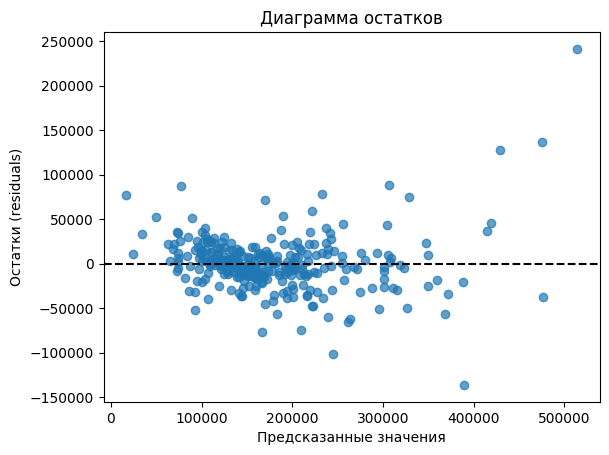

In [70]:
# Диаграмма остатков.
# Хорошая модель не имеет закономерностей в остатках (они должны быть равномерно распределены вокруг нуля).
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки (residuals)")
plt.title("Диаграмма остатков")
plt.show()

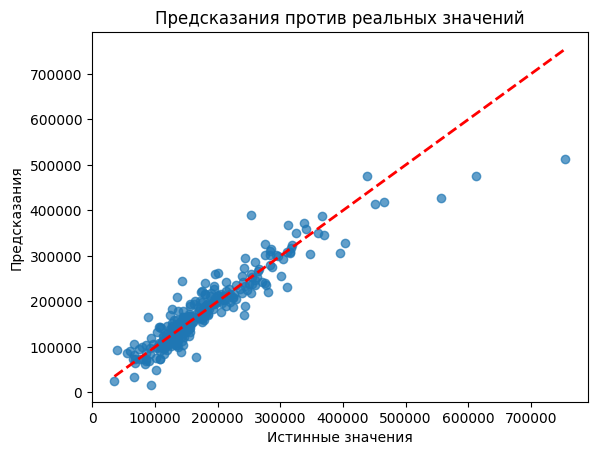

In [71]:
# График предсказаний vs. истинных значений:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.title("Предсказания против реальных значений")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

<Axes: xlabel='feature'>

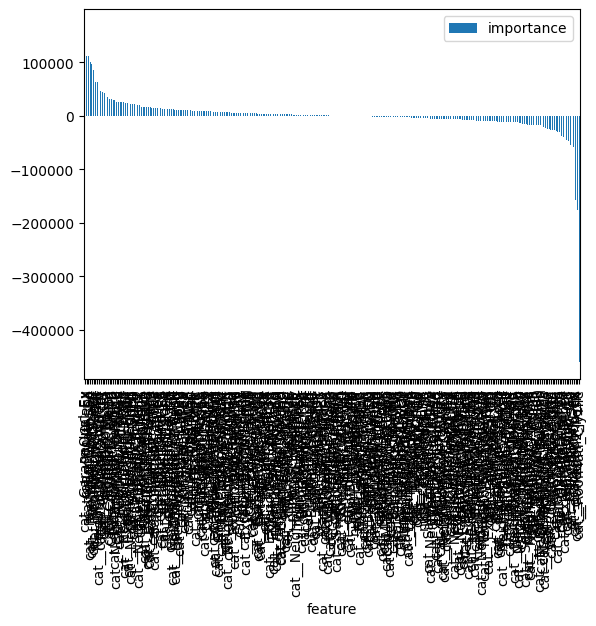

In [72]:
# Важность признаков. Важно: важности признаков для линейной регрессии определяется через абсолютные значения оных. Т.е. важны очень как отрицательные, так и положительные признаки, а вот те, которые около нуля, можно считать не важными. Для RandomForest важны только положительные значения, поэтому там можно отсекать те фичи, которых важности меньше нуля.
# Извлекаем имена признаков после ColumnTransformer
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Важности признаков из RandomForest
# importances = model_pipeline.named_steps['model'].feature_importances_
# Важности признаков из LinearRegression
importances = model_pipeline.named_steps['model'].coef_

# Строим график
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importances.sort_values(by='importance', ascending=False).plot.bar(x='feature', y='importance')

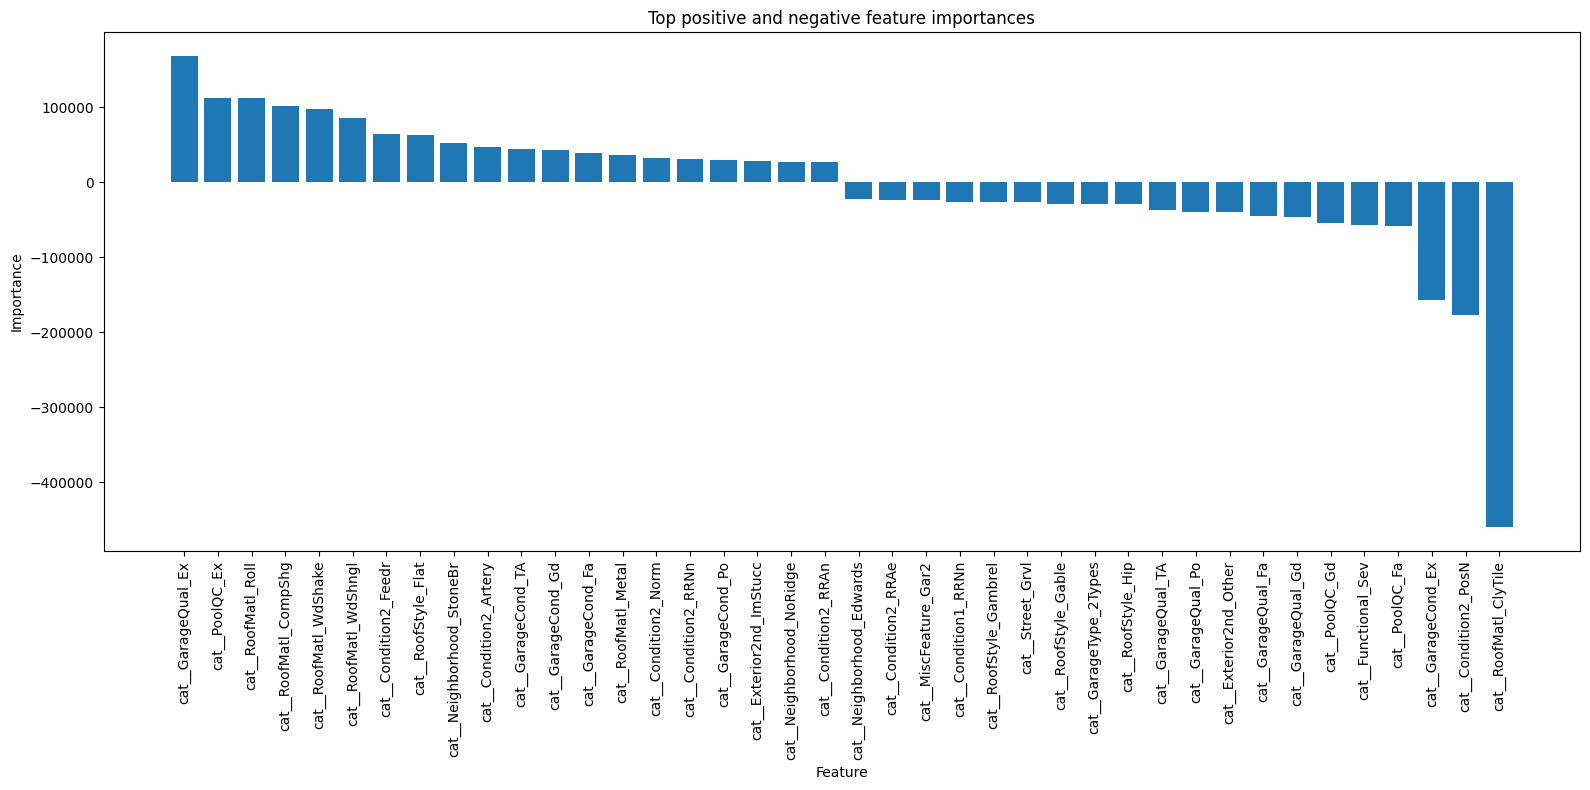

In [73]:
# Отображаем только топ-40 самых важных признаков: 20 самых положительно влияющих и 20 самых отрицательно влияющих
# Сортируем признаки по важности
df_importances_sorted = df_importances.sort_values(by='importance', ascending=False)

# Выбираем топ-20 самых важных и 20 самых отрицательно влияющих признаков
top_positive = df_importances_sorted.head(20)
top_negative = df_importances_sorted.tail(20)

# Объединяем признаки
top_features = pd.concat([top_positive, top_negative])

# Строим график с увеличенным размером
plt.figure(figsize=(16, 8))
plt.bar(top_features['feature'], top_features['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top positive and negative feature importances')
plt.tight_layout()  # автоматически подгоняет подписи, чтобы ничего не обрезалось
plt.show()

In [74]:
# Теперь можно извлечь только N самых важных признаков, которые и использовать потом для обучения модели, если это критично
# Создаем новый DataFrame с абсолютными значениями для оценки важности
df_abs_importance = pd.DataFrame({
    'feature': feature_names, 
    'abs_importance': np.abs(importances)
})

# Сортируем по абсолютной важности
df_abs_importance = df_abs_importance.sort_values(by='abs_importance', ascending=False)

# Выбираем топ-N признаков (например, 20)
top_features = df_abs_importance.head(20)['feature'].tolist()
top_features

['cat__RoofMatl_ClyTile',
 'cat__Condition2_PosN',
 'cat__GarageQual_Ex',
 'cat__GarageCond_Ex',
 'cat__PoolQC_Ex',
 'cat__RoofMatl_Roll',
 'cat__RoofMatl_CompShg',
 'cat__RoofMatl_WdShake',
 'cat__RoofMatl_WdShngl',
 'cat__Condition2_Feedr',
 'cat__RoofStyle_Flat',
 'cat__PoolQC_Fa',
 'cat__Functional_Sev',
 'cat__PoolQC_Gd',
 'cat__Neighborhood_StoneBr',
 'cat__GarageQual_Gd',
 'cat__Condition2_Artery',
 'cat__GarageQual_Fa',
 'cat__GarageCond_TA',
 'cat__GarageCond_Gd']

## 3. Сохраняем обученную модель вместе с препроцессингом

In [75]:
model_manager = ModelManager()

In [76]:
# Создаём файл (model_pipeline.pkl), где сохранены:
# 	•	обученная модель.
# 	•	все этапы обработки данных (импутация, скейлеры и т.д.).

model_manager.save_model(model_pipeline, 'model_pipeline.pkl')

## 4. Загружаем обученную модель для переиспользования

In [77]:
# loaded_pipeline = model_manager.load_model('model_pipeline.pkl')
# preds = loaded_pipeline.predict(X_new)

## 5. Пробуем другой алгоритм для модели

### 5.1. Random Forest

In [78]:
# Создаем новый пайплайн с Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Используем тот же препроцессор
    ('model', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE))
])

# Обучение Random Forest модели
rf_pipeline.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_rf = rf_pipeline.predict(X_test)

# Оценка качества модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== Random Forest ===")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² (коэффициент детерминации): {r2_rf:.4f}')

# Относительная ошибка (в процентах от среднего значения целевой переменной)
mean_target = np.mean(y_test)
print(f'Относительная ошибка (RMSE/mean): {rmse_rf/mean_target*100:.2f}%')


=== Random Forest ===
MSE: 996748540.4941
RMSE: 31571.3247
R² (коэффициент детерминации): 0.8701
Относительная ошибка (RMSE/mean): 17.65%


### 5.2. XGBoost

In [79]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Оценка качества модели
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_rf)

print("\n=== XGBoost ===")
print(f'MSE: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² (коэффициент детерминации): {r2_xgb:.4f}')

# Относительная ошибка (в процентах от среднего значения целевой переменной)
mean_target = np.mean(y_test)
print(f'Относительная ошибка (RMSE/mean): {rmse_xgb/mean_target*100:.2f}%')


=== XGBoost ===
MSE: 962759744.0000
RMSE: 31028.3691
R² (коэффициент детерминации): 0.8701
Относительная ошибка (RMSE/mean): 17.35%


### 5.3. CatBoost

In [80]:
cat_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, 
                               loss_function='RMSE', verbose=100, random_seed=RANDOM_STATE))
])

# Обучение модели
cat_pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_cat = cat_pipeline.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = root_mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("\n=== CatBoost ===")
print(f'MSE: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² (коэффициент детерминации): {r2_cat:.4f}')
# Относительная ошибка (в процентах от среднего значения целевой переменной)
mean_target = np.mean(y_test)
print(f'Относительная ошибка (RMSE/mean): {rmse_cat/mean_target*100:.2f}%')

0:	learn: 72319.8032242	total: 2.39ms	remaining: 2.38s
100:	learn: 14791.1740781	total: 148ms	remaining: 1.31s
200:	learn: 9282.7238009	total: 287ms	remaining: 1.14s
300:	learn: 6430.4926556	total: 448ms	remaining: 1.04s
400:	learn: 4766.2794609	total: 588ms	remaining: 878ms
500:	learn: 3498.4941388	total: 725ms	remaining: 722ms
600:	learn: 2737.5789132	total: 866ms	remaining: 575ms
700:	learn: 2169.2638843	total: 1s	remaining: 428ms
800:	learn: 1738.3514775	total: 1.14s	remaining: 284ms
900:	learn: 1375.6586091	total: 1.27s	remaining: 140ms
999:	learn: 1092.3363270	total: 1.41s	remaining: 0us

=== CatBoost ===
MSE: 768246572.0527
RMSE: 27717.2613
R² (коэффициент детерминации): 0.8998
Относительная ошибка (RMSE/mean): 15.50%


## 6. Экспериментируем с фичами, гиперпараметрами и пр.

In [89]:
top_features = model_manager.get_top_features(cat_pipeline, n=40)
top_features

['num__OverallQual',
 'num__GrLivArea',
 'num__1stFlrSF',
 'num__GarageCars',
 'num__BsmtFinSF1',
 'num__TotalBsmtSF',
 'cat__GarageFinish_Unf',
 'num__2ndFlrSF',
 'cat__KitchenQual_Ex',
 'num__Fireplaces',
 'num__GarageArea',
 'num__YearBuilt',
 'cat__BsmtQual_Gd',
 'num__LotArea',
 'num__YearRemodAdd',
 'cat__KitchenQual_Gd',
 'num__HalfBath',
 'num__FullBath',
 'num__OverallCond',
 'num__OpenPorchSF',
 'num__BsmtFullBath',
 'cat__BsmtExposure_No',
 'cat__LandContour_Bnk',
 'num__WoodDeckSF',
 'cat__Condition1_Norm',
 'num__MasVnrArea',
 'cat__ExterQual_Gd',
 'num__MoSold',
 'num__GarageYrBlt',
 'cat__Neighborhood_Crawfor',
 'num__MSSubClass',
 'num__BedroomAbvGr',
 'cat__Neighborhood_Edwards',
 'num__KitchenAbvGr',
 'num__BsmtUnfSF',
 'num__LotFrontage',
 'cat__BsmtExposure_Gd',
 'cat__Foundation_PConc',
 'cat__MSZoning_RM',
 'cat__BsmtFinType1_GLQ']

In [92]:
# Формируем вручную имена фич, ибо выше получили имена фич преобразованных, а нам надо имена фич исходных
top_features_initial = [
     'TotalBsmtSF',
     'GarageFinish',
     '2ndFlrSF',
     'KitchenQual',
     'Fireplaces',
     'GarageArea',
     'YearBuilt',
     'BsmtQual',
     'LotArea',
     'YearRemodAdd',
     'HalfBath',
     'FullBath',
     'OverallCond',
     'OpenPorchSF'
]

top_features_initial_40 = [
    'OverallQual',
    'GrLivArea',
    '1stFlrSF',
    'GarageCars',
    'BsmtFinSF1',
    'TotalBsmtSF',
    'GarageFinish',
    '2ndFlrSF',
    'KitchenQual',
    'Fireplaces',
    'GarageArea',
    'YearBuilt',
    'BsmtQual',
    'LotArea',
    'YearRemodAdd',
    'KitchenQual',
    'HalfBath',
    'FullBath',
    'OverallCond',
    'OpenPorchSF',
    'BsmtFullBath',
    'BsmtExposure',
    'LandContour',
    'WoodDeckSF',
    'Condition1',
    'MasVnrArea',
    'ExterQual',
    'MoSold',
    'GarageYrBlt',
    'Neighborhood',
    'MSSubClass',
    'BedroomAbvGr',
    'Neighborhood',
    'KitchenAbvGr',
    'BsmtUnfSF',
    'LotFrontage',
    'BsmtExposure',
    'Foundation',
    'MSZoning',
    'BsmtFinType1'
]
top_features_initial_40 = list(set(top_features_initial_40))

In [93]:
# Эксперимент №1 - исходный набор фичей и стандартные параметры
features_v1 = X_train.columns.tolist()
result_v1 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v1)

# Эксперимент №2 - урезанный набор фичей
features_v2 = top_features_initial
result_v2 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v2)

# Эксперимент №3 - тюнинг гиперпараметров
params_v3 = {
            'iterations': 2000, 
            'learning_rate': 0.1, 
            'depth': 12, 
            'loss_function': 'RMSE', 
            'verbose': 100, 
            'random_seed': RANDOM_STATE,
        }
result_v3 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v1, model_params=params_v3)

# Эксперимент №4 - расширенный набор фичей
features_v4 = top_features_initial_40
result_v4 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v4)

# Эксперимент №1 - исходный набор фичей и стандартные параметры
features_v1 = X_train.columns.tolist()
result_v1 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v1)

# Эксперимент №2 - урезанный набор фичей
features_v2 = top_features_initial
result_v2 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v2)

# Эксперимент №3 - тюнинг гиперпараметров
params_v3 = {
    'iterations': 2000,
    'learning_rate': 0.1,
    'depth': 12,
    'loss_function': 'RMSE',
    'verbose': 100,
    'random_seed': RANDOM_STATE,
}
result_v3 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v1,
                                                        model_params=params_v3)

# Эксперимент №4 - расширенный набор фичей
features_v4 = top_features_initial_40
result_v4 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v4)

# Эксперимент №5 - расширенный набор фичей + гиперпараметры
params_v5 = {
    'iterations': 2000,
    'learning_rate': 0.1,
    'depth': 12,
    'loss_function': 'RMSE',
    'verbose': 100,
    'random_seed': RANDOM_STATE,
}
result_v5 = model_manager.train_evaluate_catboost_model(X_train, X_test, y_train, y_test, features_v4, model_params=params_v5)

0:	learn: 72319.8032242	total: 2.11ms	remaining: 2.1s
100:	learn: 14791.1740781	total: 144ms	remaining: 1.28s
200:	learn: 9282.7238009	total: 291ms	remaining: 1.16s
300:	learn: 6430.4926556	total: 434ms	remaining: 1.01s
400:	learn: 4766.2794609	total: 576ms	remaining: 860ms
500:	learn: 3498.4941388	total: 719ms	remaining: 717ms
600:	learn: 2737.5789132	total: 865ms	remaining: 574ms
700:	learn: 2169.2638843	total: 1.01s	remaining: 430ms
800:	learn: 1738.3514775	total: 1.16s	remaining: 287ms
900:	learn: 1375.6586091	total: 1.3s	remaining: 143ms
999:	learn: 1092.3363270	total: 1.44s	remaining: 0us
0:	learn: 72864.1887524	total: 626us	remaining: 626ms
100:	learn: 19029.9115903	total: 44.8ms	remaining: 399ms
200:	learn: 13408.5377525	total: 92.8ms	remaining: 369ms
300:	learn: 9924.6481815	total: 143ms	remaining: 333ms
400:	learn: 8049.5123866	total: 195ms	remaining: 291ms
500:	learn: 6587.5767285	total: 243ms	remaining: 242ms
600:	learn: 5614.6024350	total: 294ms	remaining: 195ms
700:	learn

In [95]:
results = pd.DataFrame({
    'experiment': ['original_features', 'reduced_features', 'tuned_params', 'more_features', 'more_features_tuned'],
    'MSE': [result_v1['mse'], result_v2['mse'], result_v3['mse'], result_v4['mse'], result_v5['mse']],
    'RMSE': [result_v1['rmse'], result_v2['rmse'], result_v3['rmse'], result_v4['rmse'], result_v5['rmse']],
    'RMSE %': [result_v1['rmse %'], result_v2['rmse %'], result_v3['rmse %'], result_v4['rmse %'], result_v5['rmse %']],
    'R2': [result_v1['r2'], result_v2['r2'], result_v3['r2'], result_v4['r2'], result_v5['r2']]
})
results

,experiment,MSE,RMSE,RMSE %,R2
0,original_features,7.682466e+08,27717.261265,15.498373,0.899842
1,reduced_features,9.716094e+08,31170.649997,17.429369,0.873329
2,tuned_params,1.326615e+09,36422.728914,20.366119,0.827046
3,more_features,7.705101e+08,27758.064077,15.521188,0.899547
4,more_features_tuned,1.128958e+09,33599.968324,18.787745,0.852815


## 7. Формируем Submission файл для Kaggle используя лучшую модель

In [48]:
bad_columns = dm.get_all_nan_cols(test_data)
bad_columns.append('Id')
X_submission = test_data.drop(columns=bad_columns)
X_submission.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [49]:
y_submission = cat_pipeline.predict(X_submission)
y_submission

array([120535.27420816, 158110.09288093, 184518.65740529, ...,
       174166.03025438, 124378.22039744, 218313.10739352])

In [54]:
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_submission
})
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
1461,120535.274208
1462,158110.092881
1463,184518.657405
1464,196977.754513
1465,211490.575391


In [55]:
submission.to_csv('submission.csv')

## Сохраняем лучшую модель

In [63]:
model_manager.save_model(cat_pipeline, 'catboost_model.pkl')